<a href="https://colab.research.google.com/github/kabindrashrsth/recycleNet/blob/main/Recycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/Spring\ 2021/Deep\ Learning/Final\ Project

/content/gdrive/MyDrive/Spring 2021/Deep Learning/Final Project


In [3]:
! pip install torch_utils

  Created wheel for torch-utils: filename=torch_utils-0.1.2-cp37-none-any.whl size=6203 sha256=de1ad55f7e9958df576b332855a8c6e8abb9cc7b4bca28202e83a99cba48143c
  Stored in directory: /root/.cache/pip/wheels/95/61/06/139d254fa820bc1e45087dba1d719bc7d4007aec98905179c7
Successfully built torch-utils


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf
import torchvision
import zipfile
import random
import shutil

from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np

import os

# Image manipulations
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Webcam Object Recognition
import base64 # used to encode and decode data
import html
import io # for file related input/output operations
import time 

from IPython.display import display, Javascript
from google.colab.output import eval_js
from PIL import Image
import cv2



In [ ]:
# extracting dataset
files = zipfile.ZipFile("dataset-resized.zip", 'r')
files.extractall()
files.close()

In [ ]:
os.listdir(os.path.join(os.getcwd(), "dataset-resized"))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash', '.DS_Store']

In [ ]:
## helper functions to organize data into different folders ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.7*n))
    # train = random.sample(list(range(1,n+1)),int(.8*n))


    ## temp
    # remain = list(set(full_set)-set(train))
    valid = list(set(full_set)-set(train))


    # separate remaining into validation and test
    random.seed(seed2)
    # valid = random.sample(remain,int(.5*len(remain)))
    # test = list(set(remain)-set(valid))
    
    # return(train,valid,test)
    return(train,valid)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [ ]:
# organize data into different folders
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    # train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    train_ind, valid_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    # ## move source files to test
    # test_names = get_names(waste_type,test_ind)
    # test_source_files = [os.path.join(source_folder,name) for name in test_names]
    # ## I use data/test here because the images can be mixed up
    # move_files(test_source_files,"data/test")

Error: ignored

In [5]:
# define paths and parameters
traindir = f"data/train"
validdir = f"data/valid"
# testdir = f"data/valid"

save_file_name = f'resnet50-transfer.pt'
checkpoint_path = f'resnet50-transfer.pth'

# Change to fit hardware
batch_size = 8

In [6]:
# define transforms
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
        transforms.Compose([       
            transforms.RandomResizedCrop(size=224),
            transforms.RandomRotation(90),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.4), #these values are random
            transforms.RandomHorizontalFlip(), 
            
            transforms.CenterCrop(size=224),  # Image net standards
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])  # Imagenet standards
        ]),
    # Validation does not use augmentation
    'valid':
        transforms.Compose([
            transforms.Resize(size=256),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
}

<Figure size 1728x1728 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


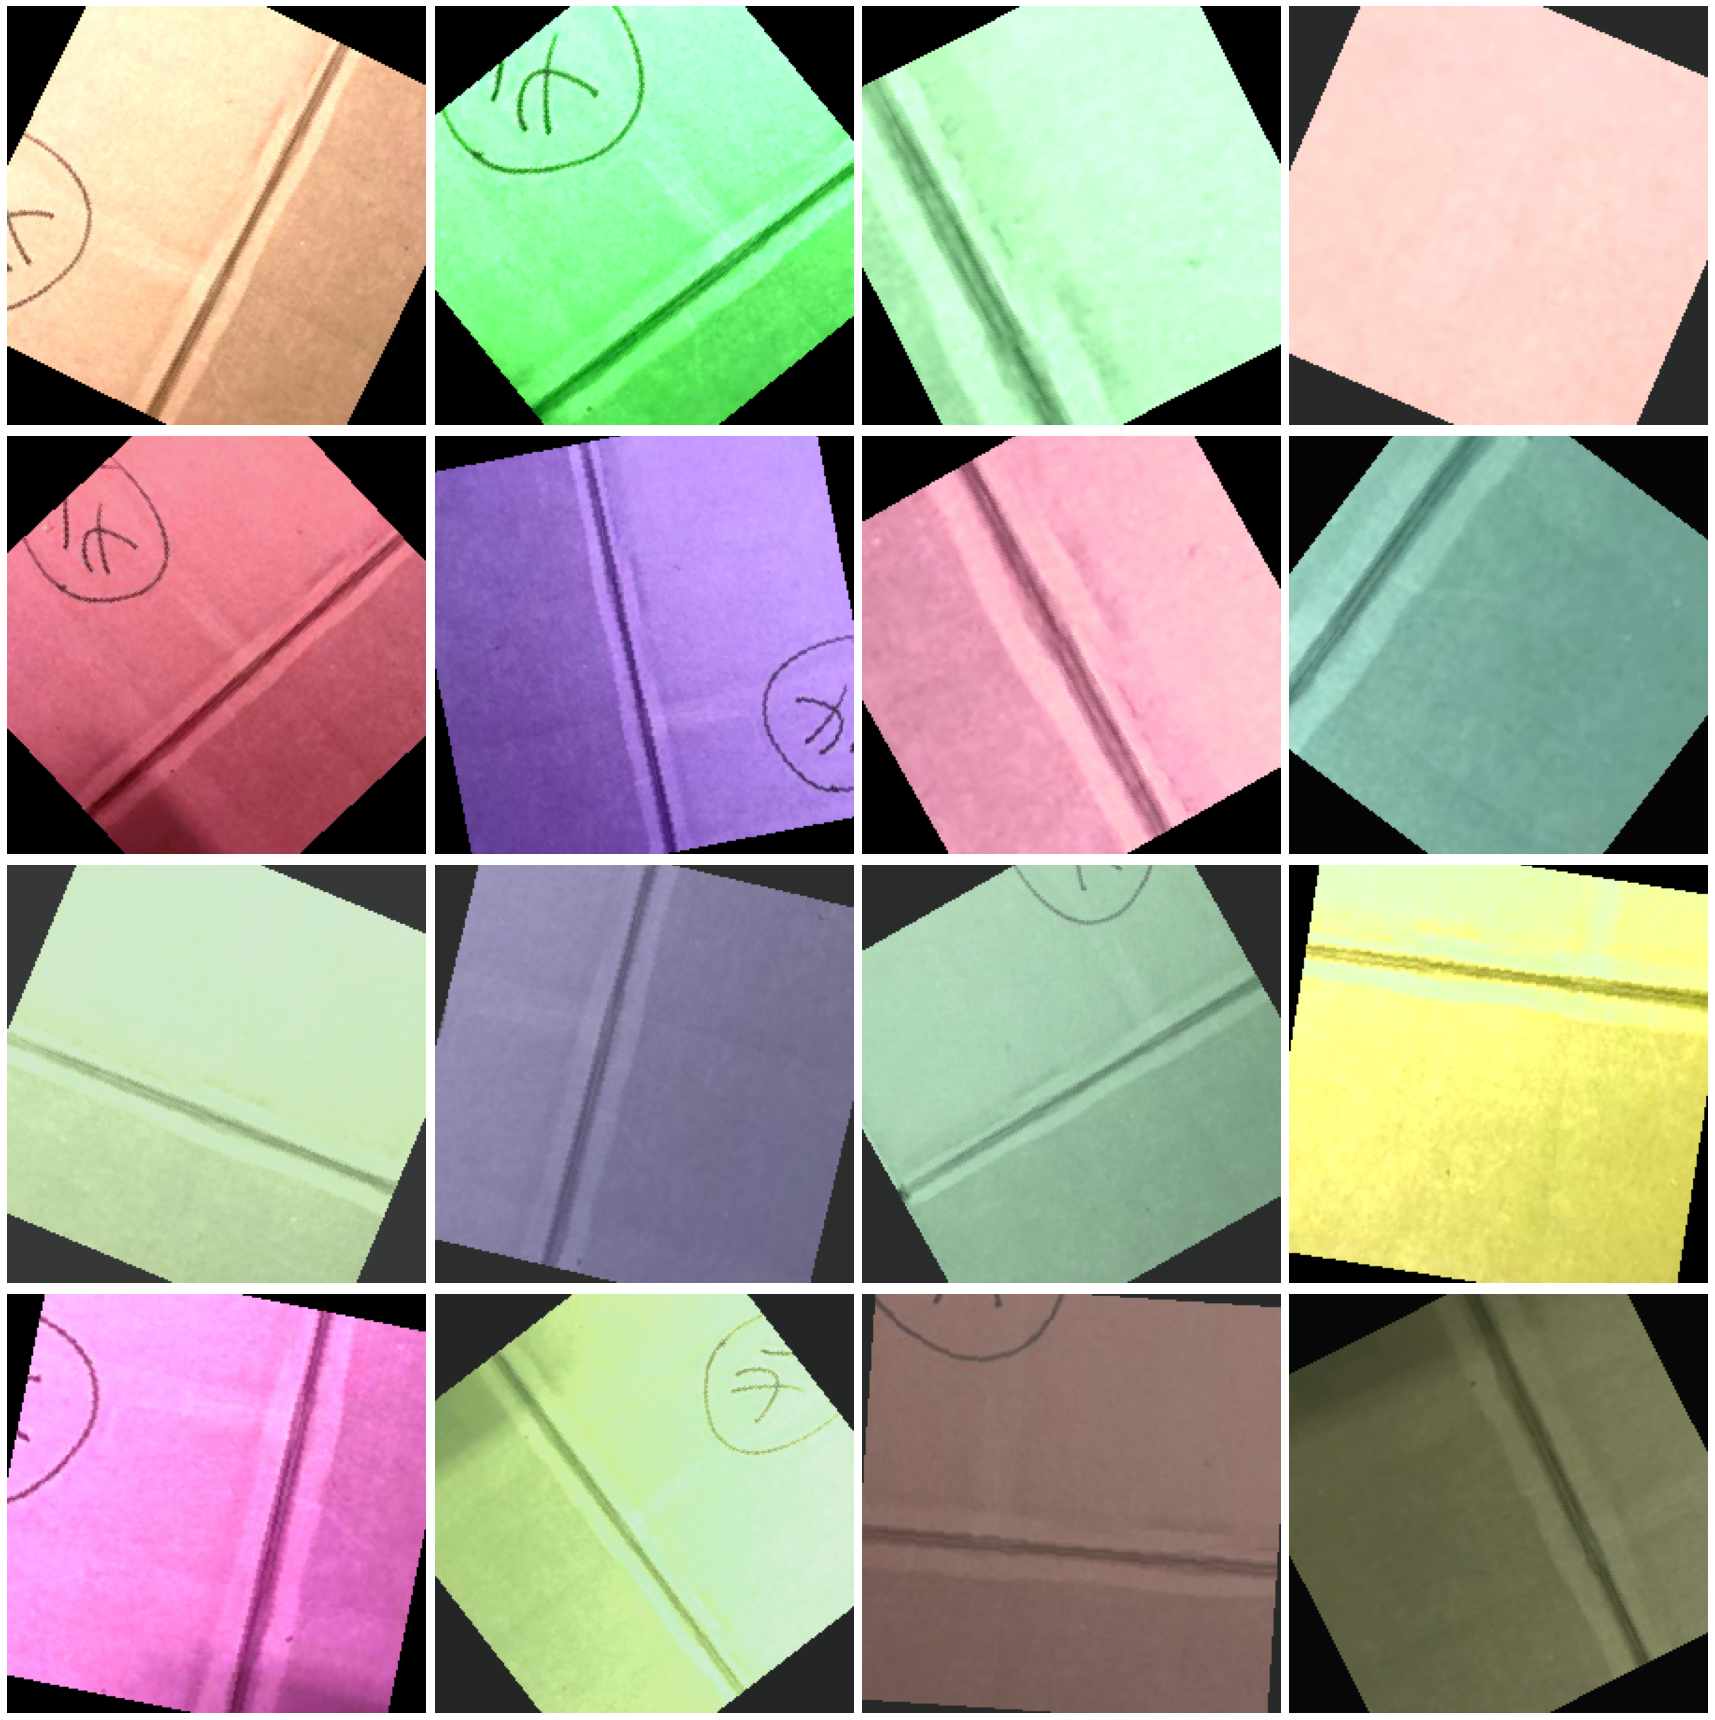

In [7]:
# take a look at data augmentation

def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots
# print("label ", labels[0].long())
# print("0row output ", output[0].long())
# print("output ", output.data)
# print("adf ", torch.max(output.data, 1))()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
 
    np.clip(image, 0, 1)
  
    ax.imshow(image)
    plt.axis('off')

    return ax, image

    
ex_img = Image.open('data/train/cardboard/cardboard1.jpg')

t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()
plt.show()

In [8]:
# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['valid']),
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10),
}

# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
validationiter = iter(dataloaders['val'])

categories = []
for d in os.listdir(traindir):
    categories.append(d)

n_classes = len(categories)
print(f'There are {n_classes} different classes.')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


There are 6 different classes.


In [9]:
model = models.resnet50(pretrained=True)

# Freeze model weights
# You need to go throught all the parameters in model.parameters()
# You need to set "requires_grad" to "False" for all parameters
for param in model.parameters():
    param.requires_grad = False

# print(model)

# You may get the number of the features from the feature layer of the pretrained network
# You can use model.fc.in_features to get the feature number
num_in_feat = model.fc.in_features

model.fc = nn.Sequential(
                      nn.Linear(num_in_feat, 256), # are these number okay?
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(256, 25),
                      nn.LogSoftmax(dim=1))
                      
model.fc

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=256, out_features=25, bias=True)
  (4): LogSoftmax(dim=1)
)

24,039,001 total parameters.
530,969 training parameters.


In [10]:
# Check whether there is a gpu 

train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

if train_on_gpu:
    model = model.to('cuda')


Train on gpu: True
1 gpus detected.
True False


In [11]:
if train_on_gpu:
  model = model.to('cuda')

In [12]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())


#  criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

[(0, 'cardboard'),
 (1, 'glass'),
 (2, 'metal'),
 (3, 'paper'),
 (4, 'plastic'),
 (5, 'trash')]

torch.Size([256, 2048])
torch.Size([256])
torch.Size([25, 256])
torch.Size([25])


In [13]:
# You can use your train function in HW3
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0
       

        # Set to training
  
        model.train()
        
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            
            # Tensors to gpu
            
            if train_on_gpu:
                model = model.cuda()
                data, target = data.cuda(), target.cuda()
           

            # Clear gradients
            optimizer.zero_grad()

            # Get your output from your model
          
            model = model.float()
            output = model(data.float())

            # Loss and backpropagation of gradients
            
            loss = criterion(output, target.long())
            loss.backward()

            # Update the parameters
            optimizer.step(

            # Track train loss by multiplying average loss by number of examples in batch
            
            train_loss += loss.item() * data.size(0)
            


            # Calculate accuracy by finding max log probability
            
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
           

            # Need to convert correct tensor from int to float to average
            
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            

            # Multiply average accuracy times the number of examples in batch
            
            train_acc += accuracy.item() * data.size(0)
            

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                
                model.eval()
                

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    
                    if train_on_gpu:
                        model = model.cuda()
                        data, target = data.cuda(), target.cuda()
                    
                    # Forward pass                    
                    model = model.float()
                    output = model(data.float())
                    
                    # Validation loss
                    loss = criterion(output, target.long())
                    
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)
                    
                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                    

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)
                

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)
                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict                        
                        model.load_state_dict(torch.load(save_file_name))
                        
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [14]:
from timeit import default_timer as timer
save_file_name = f'resnet-50_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(model,
    criterion,
    optimizer,
    dataloaders['train'], 
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=500,
    print_every=1)

Starting Training from Scratch.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Epoch: 0 	Training Loss: 1.7912 	Validation Loss: 1.3153
		Training Accuracy: 31.99%	 Validation Accuracy: 66.36%

Epoch: 1 	Training Loss: 1.4336 	Validation Loss: 1.1694
		Training Accuracy: 45.98%	 Validation Accuracy: 61.76%

Epoch: 2 	Training Loss: 1.3365 	Validation Loss: 1.0961
		Training Accuracy: 49.26%	 Validation Accuracy: 61.37%

Epoch: 3 	Training Loss: 1.2197 	Validation Loss: 0.9422
		Training Accuracy: 55.15%	 Validation Accuracy: 69.38%

Epoch: 4 	Training Loss: 1.1936 	Validation Loss: 0.8848
		Training Accuracy: 54.13%	 Validation Accuracy: 69.78%

Epoch: 5 	Training Loss: 1.1626 	Validation Loss: 0.9243
		Training Accuracy: 56.91%	 Validation Accuracy: 64.91%

Epoch: 6 	Training Loss: 1.1435 	Validation Loss: 0.8451
		Training Accuracy: 56.80%	 Validation Accuracy: 71.75%

Epoch: 7 	Training Loss: 1.1097 	Validation Loss: 0.8783
		Training Accuracy: 58.04%	 Validation Accuracy: 68.33%

Epoch: 8 	Training Loss: 1.0928 	Validation Loss: 0.7969
		Training Accuracy: 5

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

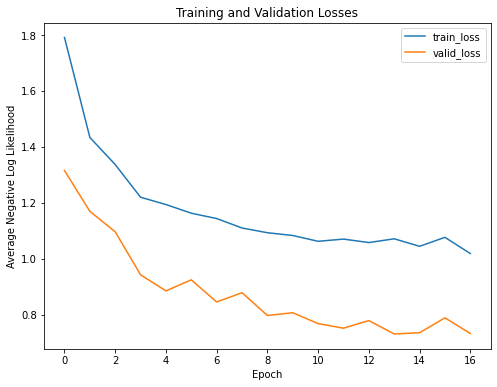

In [15]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

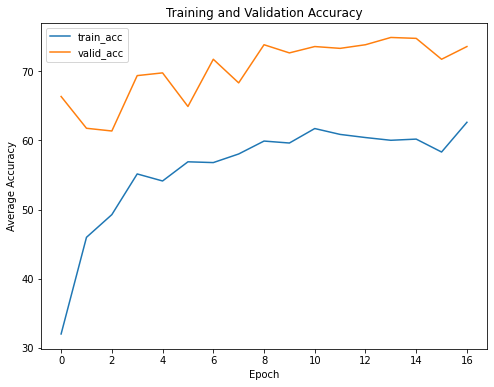

In [16]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


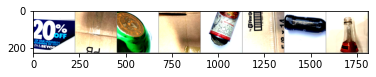

GroundTruth:  paper cardboard glass cardboard metal cardboard glass glass
Prediction:  paper cardboard glass glass metal cardboard glass glass


In [17]:
# demo from validation data
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = npimg.transpose(1,2,0)

    plt.imshow(npimg)
    plt.show()


dataiter = iter(validationiter)
# get some random training images
images, labels = dataiter.next()

# Get the prediction of images by using your model.
if train_on_gpu:
  model = model.cuda()
  images, labels = images.cuda(), labels.cuda()

model = model.float()

output = model(images.float())

_, predicted = torch.max(output.data, 1)

images = images.cpu()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % categories[labels[j].long()] for j in range(batch_size)))
print('Prediction: ', ' '.join('%5s' % categories[predicted[j].long()] for j in range(batch_size)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


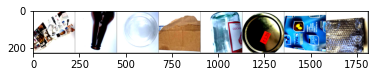

GroundTruth:  paper glass plastic cardboard glass glass paper plastic
Prediction:  paper glass plastic cardboard glass metal paper metal


In [19]:
# demo from testing data
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = npimg.transpose(1,2,0)

    plt.imshow(npimg)
    plt.show()


# get some random training images
images, labels = dataiter.next()

# Get the prediction of images by using your model.
if train_on_gpu:
  model = model.cuda()
  images, labels = images.cuda(), labels.cuda()

model = model.float()

output = model(images.float())

_, predicted = torch.max(output.data, 1)

images = images.cpu()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % categories[labels[j].long()] for j in range(batch_size)))
print('Prediction: ', ' '.join('%5s' % categories[predicted[j].long()] for j in range(batch_size)))

In [20]:
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [21]:
# Convert JavaScript output (a bytes format) to the image in an array format in order to load it into our model.
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    # First, change the byte image to a Image format.
    # You can use Image.open() to open the Javascript image: io.BytesIO(jpeg_bytes)
    # Then, change the image_PIL to a array format.
    # You can use np.array() to convert a Image format to a array format
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)
    return image_array

In [22]:
#!git clone https://github.com/cwq159/PyTorch-Spiking-YOLOv3
#%cd PyTorch-Spiking-YOLOv3
import argparse
from sys import platform
from torchvision import models
from models import *

# Load all the function from utils/datasets.py
# Load all the function from utils/utils.py
# You can use utils.datasets and utils.utils to define the path of python files
# You can use * to import all function from one python file

from utils.datasets import *
from utils.utils import *

parser = argparse.ArgumentParser()
#parser.add_argument('--cfg', type=str, default='cfg/yolov3-tiny.cfg', help='*.cfg path')
#parser.add_argument('--cfg', type=str, default='cfg/resnet50.cfg', help='*.cfg path')
#parser.add_argument('--names', type=str, default='data/coco.names', help='*.names path')
#parser.add_argument('--weights', type=str, default='weights/yolov3-tiny.pt', help='weights path')

# Input the path of your pretrianed model file here
parser.add_argument('--weights', type=str, default='weights/resnet-50_model_best_model.pt', help='weights path')
parser.add_argument('--img-size', type=int, default=416, help='inference size (pixels)')
#parser.add_argument('--conf-thres', type=float, default=0.0, help='object confidence threshold')
#parser.add_argument('--iou-thres', type=float, default=0.6, help='IOU threshold for NMS')
#parser.add_argument('--classes', nargs='data/classes.txt', type=int, help='filter by class')
#parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
opt = parser.parse_args(args = [])

_StoreAction(option_strings=['--weights'], dest='weights', nargs=None, const=None, default='weights/resnet-50_model_best_model.pt', type=<class 'str'>, choices=None, help='weights path', metavar=None)

_StoreAction(option_strings=['--img-size'], dest='img_size', nargs=None, const=None, default=416, type=<class 'int'>, choices=None, help='inference size (pixels)', metavar=None)

In [23]:
opt.classes = 'data/classes.txt'
# Get names and colors
# You can use load_classes() function to get the names
# The path of the txt file is opt.classes
# You can take a look at utils/utils.py to check the input of this function
names = load_classes(opt.classes)
print(names)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

['CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC', 'TRASH']


In [24]:
def get_drawing_array(image_array, model): 
    """
    input: 
          image_array: image array RGB size 512 x 512 from webcam
    output: 
          drawing_array: image RGBA size 512 x 512 only contain bounding box and text, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0
    """
    drawing_array = np.zeros([512,512,4], dtype=np.uint8)
    img = letterbox(image_array, new_shape=opt.img_size)[0]

    # change the image dimesion for model from [height, width, RGB_channel] to [RGB_channel, height, width]
    # You can use np.transpose() to change the order of dimensions.

    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)

    # In order to load the data to your model, we need to change the image to tensor and use GPU
    # You can use torch.from_numpy() to change your array image to a tensor
    # You can use .to(device) to use GPU

    img = torch.from_numpy(img).to(device)


    # The original RGB image is uint8 type in range (0,255). We need to change the data to float type and normalize it to (0,1).
    # You can use .float() to change the iamge type
    # You can divide the data by 255 to normalize the data.

    img = img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0


    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Do the forward pass to get the outputs
    model = model.float()
    output = model(img)

    # Get the maximum value of the prediction as a confidence value and its index to determine the class number
    # You can use torch.max()
    value, predicted = torch.max(output.data, 1)
 
    # Apply NMS
    #pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)

    # Process detections
    # det = pred[0]

    det = torch.tensor([[2.0e+01, 9.9e+01, 2.0e+01, 9.9e+01, value, predicted]])

    if det is not None and len(det):
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], image_array.shape).round()

        # Write results
        for *xyxy, conf, cls in det:
            label = 'This is %s, confidence: %.2f' % (names[int(cls)], conf)
            plot_one_box(xyxy, drawing_array, label=label, color=colors[int(cls)])

    drawing_array[:,:,3] = (drawing_array.max(axis = 2) > 0 ).astype(int) * 255

    return drawing_array

In [25]:
def drawing_array_to_bytes(drawing_array):
    """
    input: 
          drawing_array: image RGBA size 512 x 512 
                              contain bounding box and text from yolo prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0
    output: 
          drawing_b64: string, encoded from drawing_array
    """
    # Convert the image from an array format to a Image format.
    # You can use Image.fromarray() to finish the transform. The "mode" should be 'RGBA'.
    # The Image variable could be "drawing_PIL".
    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    # Save the Image for Javascript encoding.
    # You can use drawing_PIL.save() to save your image with Image format.
    # The "path" should be iobuf, the "format" should be 'png').
    drawing_PIL.save(iobuf, format='png')

    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

In [27]:
# Initialize
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break

    image = js_reply_to_image(js_reply)
    drawing_array = get_drawing_array(image, model) 
    drawing_bytes = drawing_array_to_bytes(drawing_array)
    img_data = drawing_bytes

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored